# A Quantitative Analytical Solution Applicable to any Ticker:
Welcome to my project, it is intended to povide a comprehensive quantitative analytical solution to a user curious about equities. Upon running the second cell, the user will be asked to provide a ticker, for which the analysis will be provided. 

The Analysis is detailed as follows:

- Quantitative Analysis - A statistics-informed method of financial analysis, with measures for assessing investment risk and profitability among myriad other uses.
  - Logarithmic (Continuously Compounded) Returns.
  - Beta (Sensitivity to the market)/on a rolling basis $\beta$.      
  - Standard Deviation (Volatility of the equity's returns) $\sigma$.
  - Excess returns on the risk free rate ($r_f$) and those of the market $r_p = r_i-r_f$ and $r_p = r_i-r_m$, respectively.
  - Sharpe Ratio (Excess returns for a given unit of risk) $S=\frac{r_i-r_f}{\sigma_i}$.
  - Alpha (Excess return on the market) under the CAPM and Five Factor model, both of which calculte that the expected return of an asset is a product of the inherent riskiness of that asset (i.e. its *'risk premium'*), and, with the Five Factor Method, the *return spread* (comparative performance) of companies in the market in comparison to eachother: Large vs. Small companies, High vs. Low value companies, Most profitable  vs. Least profitable and companies with Conservative vs. Aggressive investment strategies.
    - Intuitive proof for CAPM Alpha: where $E(r_i) = r_f + \beta_i(r_m-r_f)$, $\alpha_i = E(r_i) - r_f + \beta_i(r_m-r_f)$   
  - Distribution of Logarithmic Returns - the likelihood of recieving returns across the distirbution (the higher the density, the more likely, with the middle being the average, and the left and right extremities (the tails) being abnormally high and low returns, watch for these, where left tails are *'fatter'*, it means that there is an increased risk of of low returns and therefore increased susceptibility to extreme economic downturns *'Black Swans'* like the 2007/8 G.F.C.).



- Machine Learning Forecast - A stock price forecast for the next 5 days, informed by a machine learning technique.
  - The technique used was a Long Short Term Memory Algorithm, which uses nothing but the previous 5 days prices to inform its predictions for the next 5 days. It does this by repeatedly and consecutively identifyign and extracting only the useful elements of this data, on a continuous basis, to inform its continuous next 5 day prediciton.  


- Fundamental Analysis - An accounting-based method fo financial analysis, generating informative ratio-analysis on an investment's profitability, solvency (risk of bankruptcy) and recently also E.S.G. analysis, or the effective riskiness of a company relating to enironmental, social and governance risks. A low ESG-risk scoring firm therefore has a low likelihood of a scandal relating to them in any of these three areas such as: an oil spill (E), sexual harassment scandal (S), accounting scandal (G). 
  - Working Capital Ratio - the company's ability to meet it's current short-term liabilities (Debts)
  - Quick Ratio - Further measurement of solvency but only looking at the most marketable and therefore liquid assets (excluding inventory)
  - Leverage Ratio - The degree to which the company is leveraged, how much debt it has compared to equity, it is a further risk measure, for debt can be a good sign of healthy finances, however, when leverage grows too high it can lead to insolvency.
  - Earnings per Share 
  - Price to Earnings Ratio - The ratio of a company's current shareprice to its current EPS, this can be an indicator of sentiment towards a company and can thus, indicate whether a company may be over or under-valued.
  - Cash Ratio - Further measure of liquidity.
  - Net-Margin Ratio - The ratio of net profits to revenues, the higher the better. 
  - Return on Total Assets 
  - Return on Equity



- Derivatives Analysis - An intuitive measure of company risk informed by financial derivatives, assets derived from other assets, in this case and options chain. An option being an asset which gives the holder, the right, but not the obligation to buy (call) or sell (put) (typically 100 shares) of the asset at a given time in the future for a given price. 
  - The Implied Volatility Smile of a low maturity option chain provides a further intuitive assessment of inherent implied risk, demonstrating the likelihood that the stock increases/decreases in price in the short run (and greater/lower strike calls/puts go In The Money).


In [1]:
# Install libraries
# !pip install --upgrade pandas-datareader
# !pip install vectorbt
# !pip install pandas_ta 
# !pip install yfinance 
# !pip install --upgrade mplfinance
# !pip install yesg
# !pip install yahoo_fin


# import packages:
from yahoo_fin import options
from dateutil import parser as dps
from pandas_datareader.famafrench import get_available_datasets
import statsmodels.api as sm
import yfinance as yf
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math
from matplotlib import style

import os
import datetime as dt
from pandas.plotting import autocorrelation_plot

from IPython.display import Image

import matplotlib.transforms as transforms
import warnings
warnings.filterwarnings("ignore") 

import mplfinance as mpf
import  yesg as yesg
from datetime import datetime
from dateutil.relativedelta import relativedelta


In [11]:
# ticker = input('Enter chosen Ticker here: ')
ticker = 'nflx'
start = datetime.now() - relativedelta(years=5)
end = datetime.now()
stock_raw = yf.download(ticker.upper(), start=start, end=end)
spy_raw = yf.download('SPY', start=start, end=end)
ohlcv = stock_raw.loc[:,['Open', 'High', 'Low', 'Close', 'Volume']]
stock=stock_raw['Adj Close']
spy = spy_raw['Adj Close']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [12]:
# log returns
log_stock = np.log(stock/stock.shift())
log_spy = np.log(spy/spy.shift())
# cum returns
cum_ret_stock = (log_stock+1).cumprod()-1
cum_ret_spy = (log_spy+1).cumprod()-1

In [13]:
# obtain fama-french data:
fivef = pdr.DataReader('F-F_Research_Data_5_Factors_2x3_daily','famafrench',start=start, end=end)
fivef = fivef[0] # fivef is a dictionary the first part of which is the table we want.
fivef['Mkt'] = fivef['Mkt-RF'] + fivef['RF'] # obtain market returns
fivef.index.names = ['Date']

# BETA    
cov = log_stock.cov(log_spy)
var = log_spy.var()
beta = cov/var

# Rolling BETA
rolling_6m_cov = log_stock.rolling(126).cov(log_spy)
rolling_6m_var = log_spy.rolling(126).var()
rolling_6m_beta = rolling_6m_cov/rolling_6m_var

# Rolling SIGMAs
rolling_21d_std = log_stock.rolling(21).std()*np.sqrt(21)
rolling_6m_std =  log_stock.rolling(126).std()*np.sqrt(21)
rolling_ann_std = log_stock.rolling(252).std()*np.sqrt(252)
rolling_21d_std_spy = log_spy.rolling(21).std()*np.sqrt(21)
rolling_6m_std_spy =  log_spy.rolling(126).std()*np.sqrt(21)
rolling_ann_std_spy = log_spy.rolling(252).std()*np.sqrt(252)


In [14]:
# Combine FF with stock returns
log_stock = log_stock.rename(f'{ticker.upper()} Adj Close')
log_stock = log_stock.to_frame()
log_spy = log_spy.rename('SPY Adj Close')
log_spy = log_spy.to_frame()
fama_french = log_stock.join(fivef, how='inner')
fama_french = log_spy.join(fama_french, how='inner')

In [15]:
# Add Excess Returns:
fama_french['Excess_rf'] = fama_french[f'{ticker.upper()} Adj Close']-fama_french['RF']
fama_french['Excess_SPY'] = fama_french[f'{ticker.upper()} Adj Close']-fama_french['SPY Adj Close']
# Add rolling mean excess returns:
fama_french['Excess_rf_mean_126'] = fama_french['Excess_rf'].rolling(126).mean()
fama_french['Excess_SPY_mean_126'] = fama_french['Excess_SPY'].rolling(126).mean()

In [16]:
# Rolling SHARPEs:
fama_french['rm-rf'] = fama_french['SPY Adj Close']-fama_french['RF']
log_stock_6m = np.log(stock/stock.shift(126))
log_spy_6m = np.log(spy/spy.shift(126))
sharpe_stock_6m = (log_stock_6m-fama_french['RF'])/(fama_french['Excess_rf'].std()*np.sqrt(126))
sharpe_spy_6m = (log_spy_6m-fama_french['RF'])/(fama_french['Excess_rf'].std()*np.sqrt(126))

In [17]:
# CAPM alpha:
y = fama_french[f'{ticker.upper()} Adj Close'].dropna().values
x = fama_french['SPY Adj Close'].dropna().values
x = sm.add_constant(x)
capm = sm.OLS(y,x)
capm_results = capm.fit()
CAPM_beta = capm_results.params[1]
CAPM_alpha = capm_results.params[0]

# Five-Factor alpha:
y_2 = fama_french[f'{ticker.upper()} Adj Close'][1:].values
x_2= fama_french[['SPY Adj Close', 'SMB', 'HML', 'RMW', 'CMA']][1:].values
x_2 = sm.add_constant(x_2)
ff = sm.OLS(y_2,x_2)
ff_results = ff.fit()
FF_beta = ff_results.params[1]
FF_alpha = ff_results.params[0]

C:\Users\hayes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mplfinance\_styles.py:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(style['base_mpl_style'])


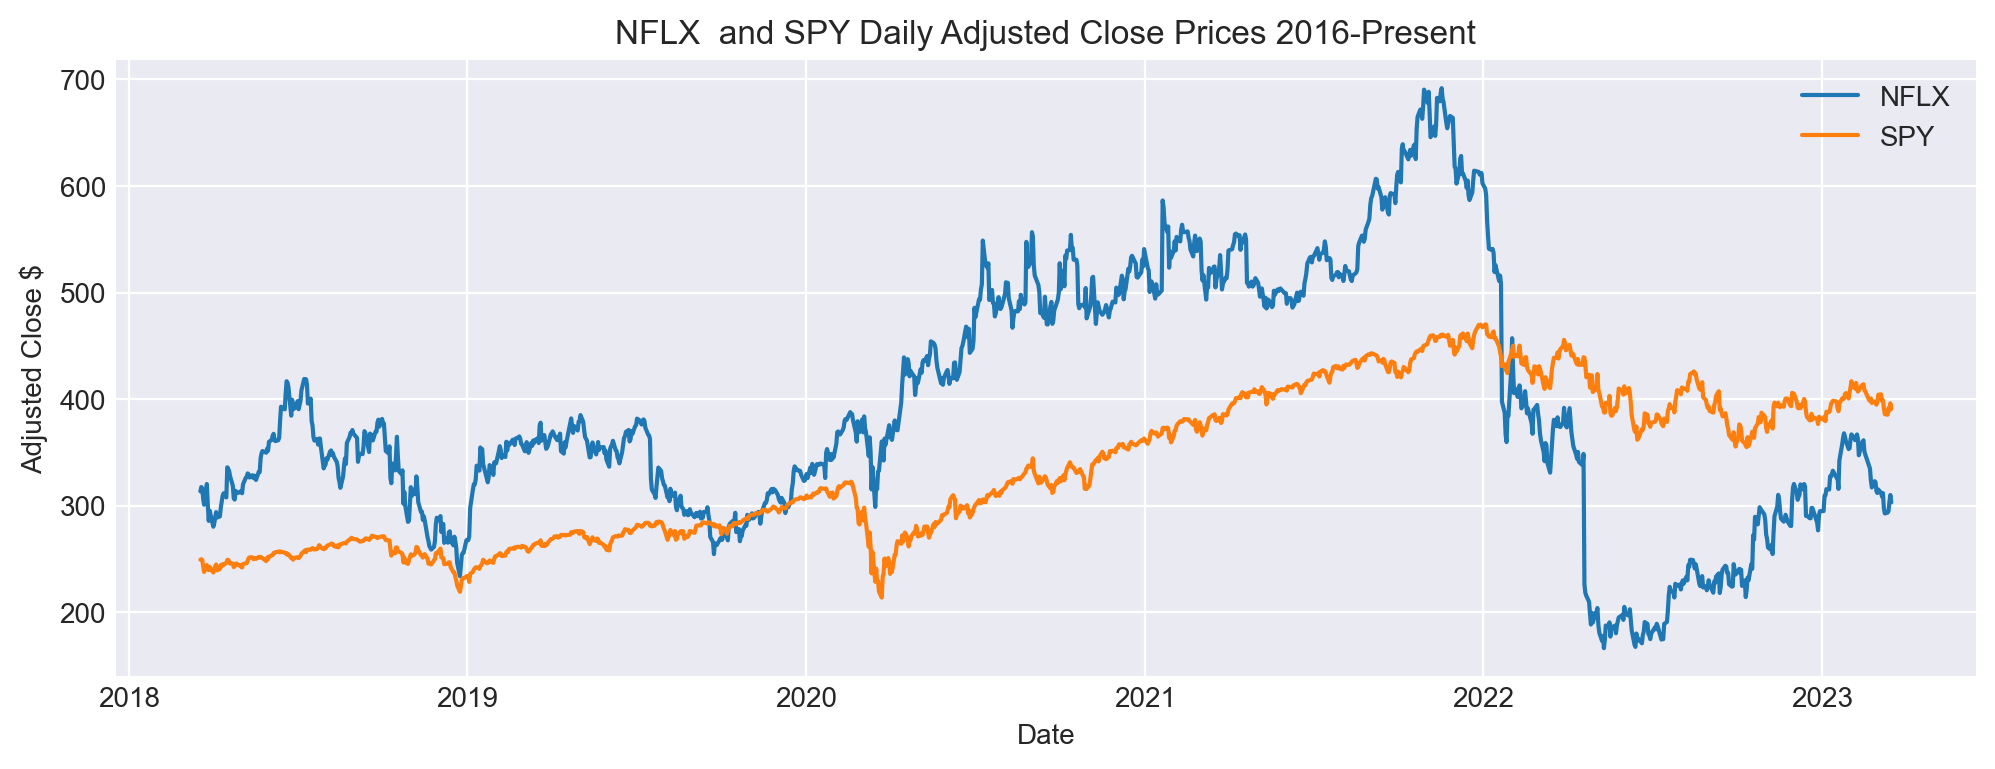

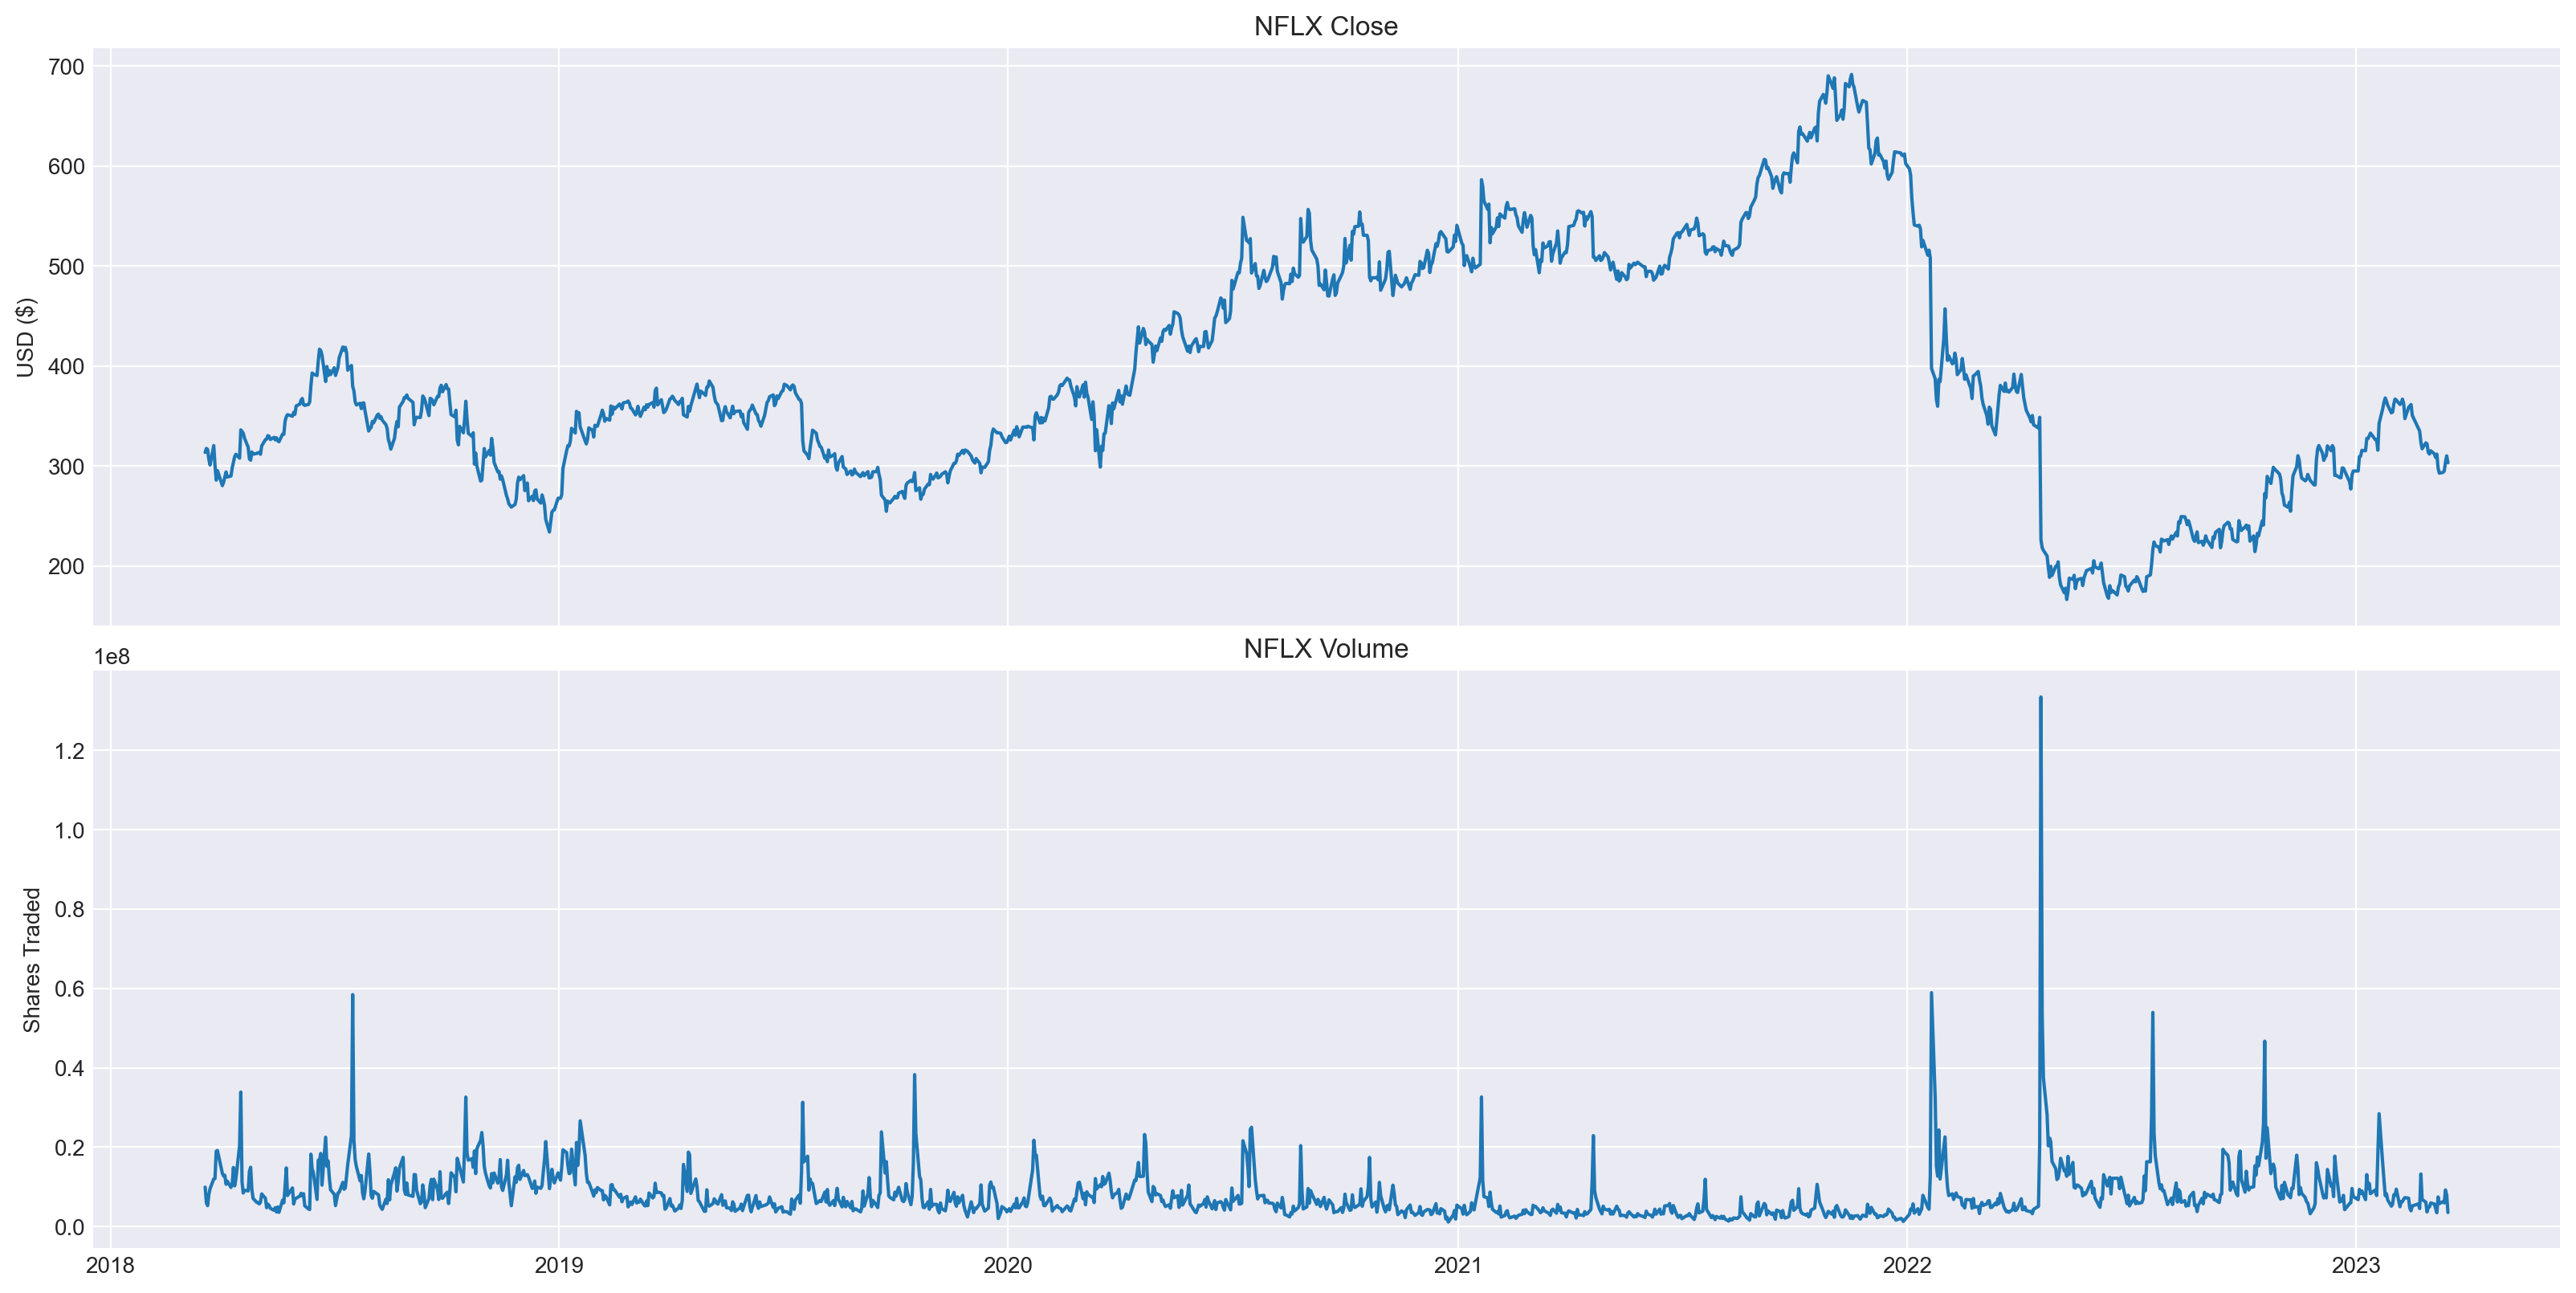

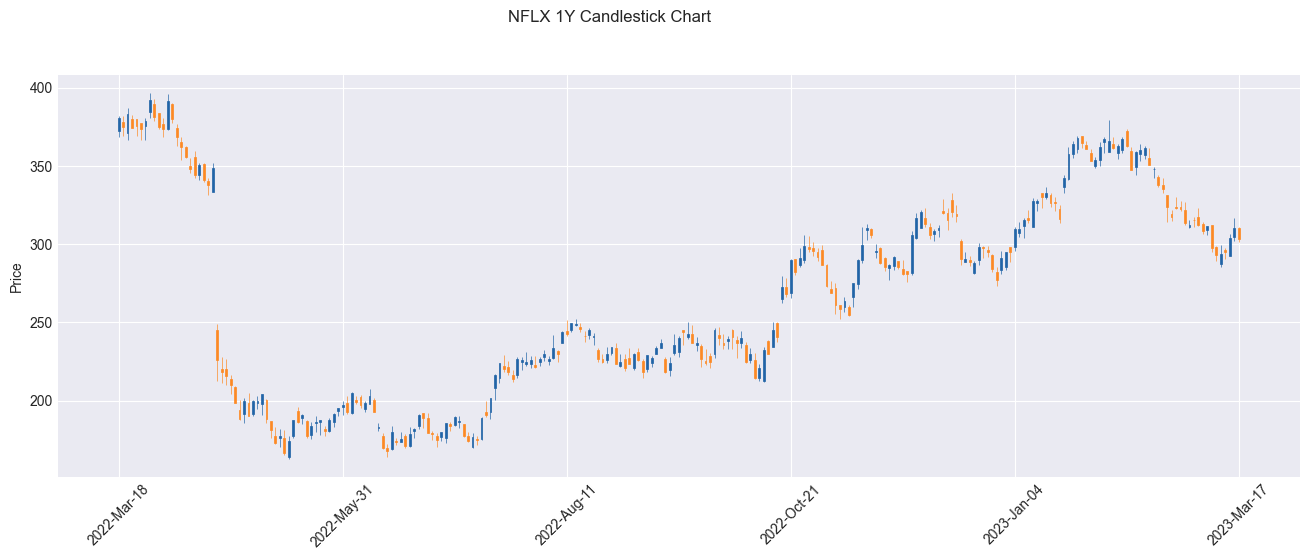

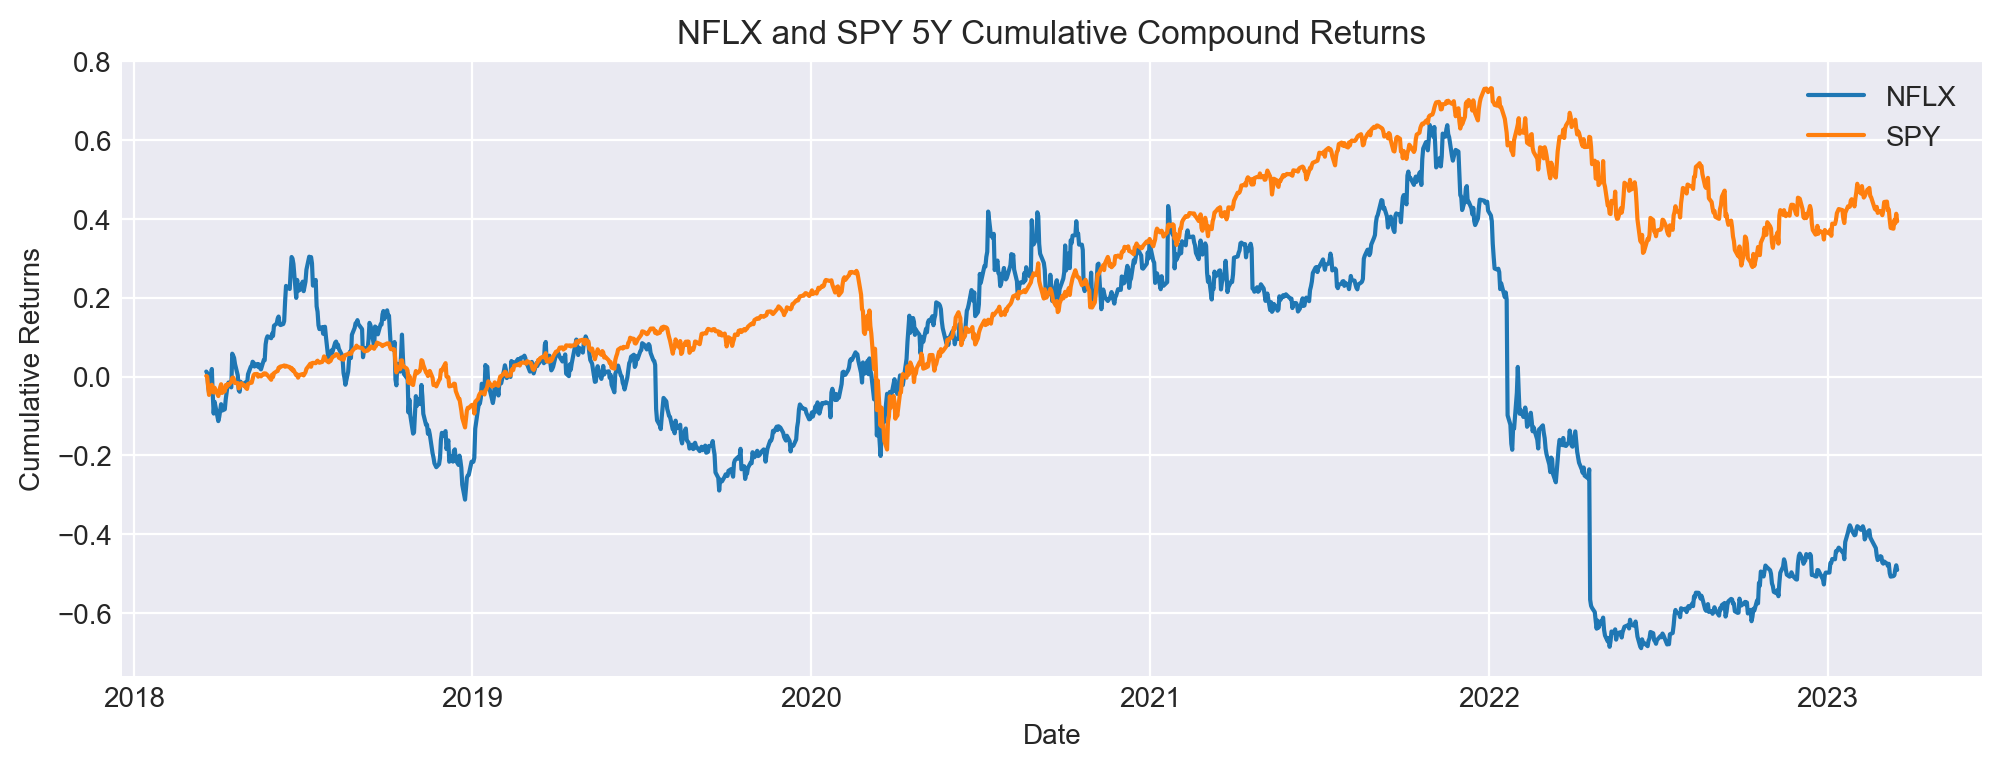

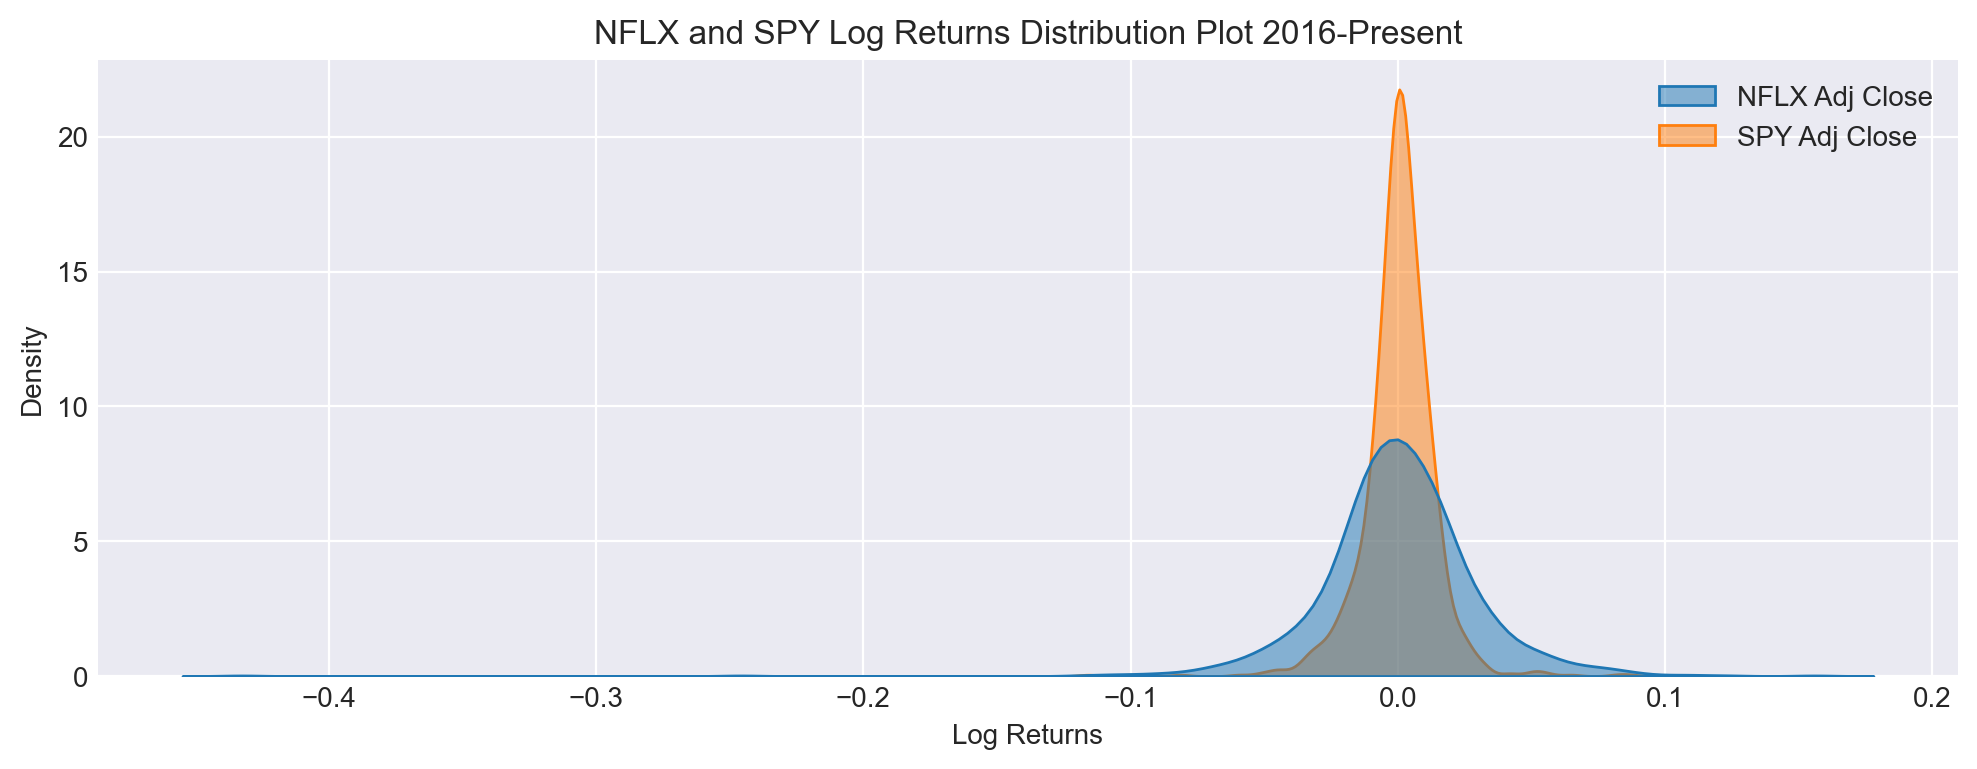

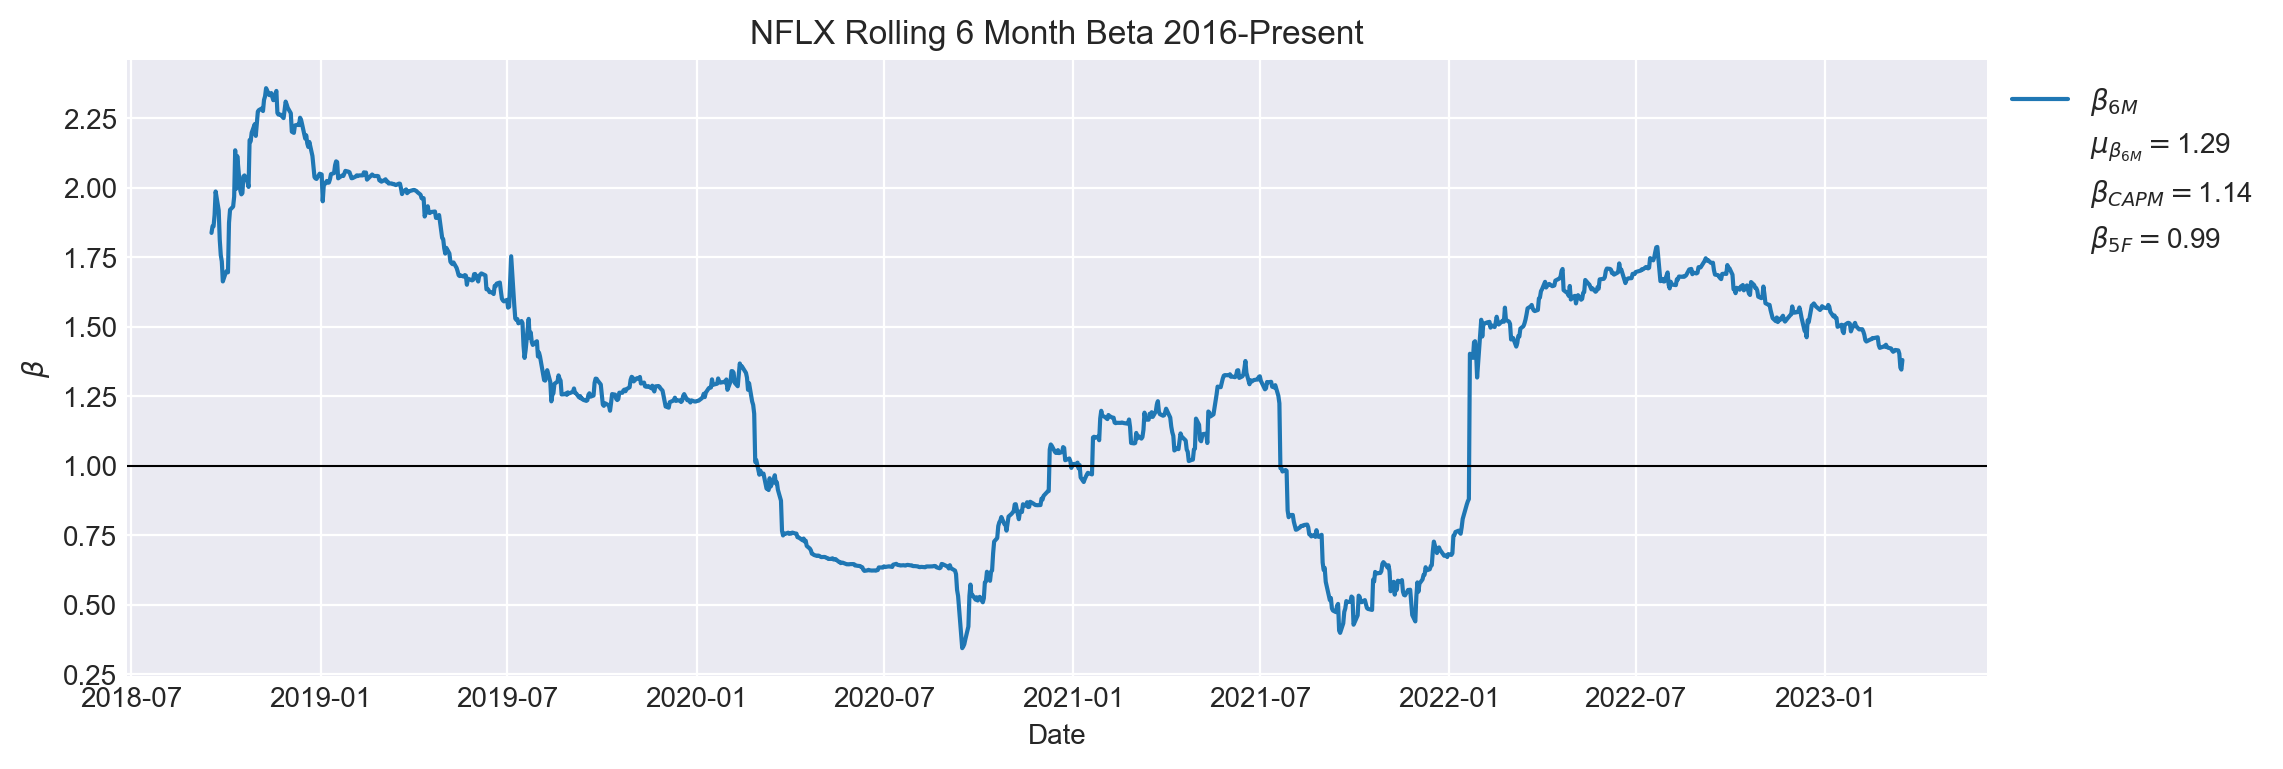

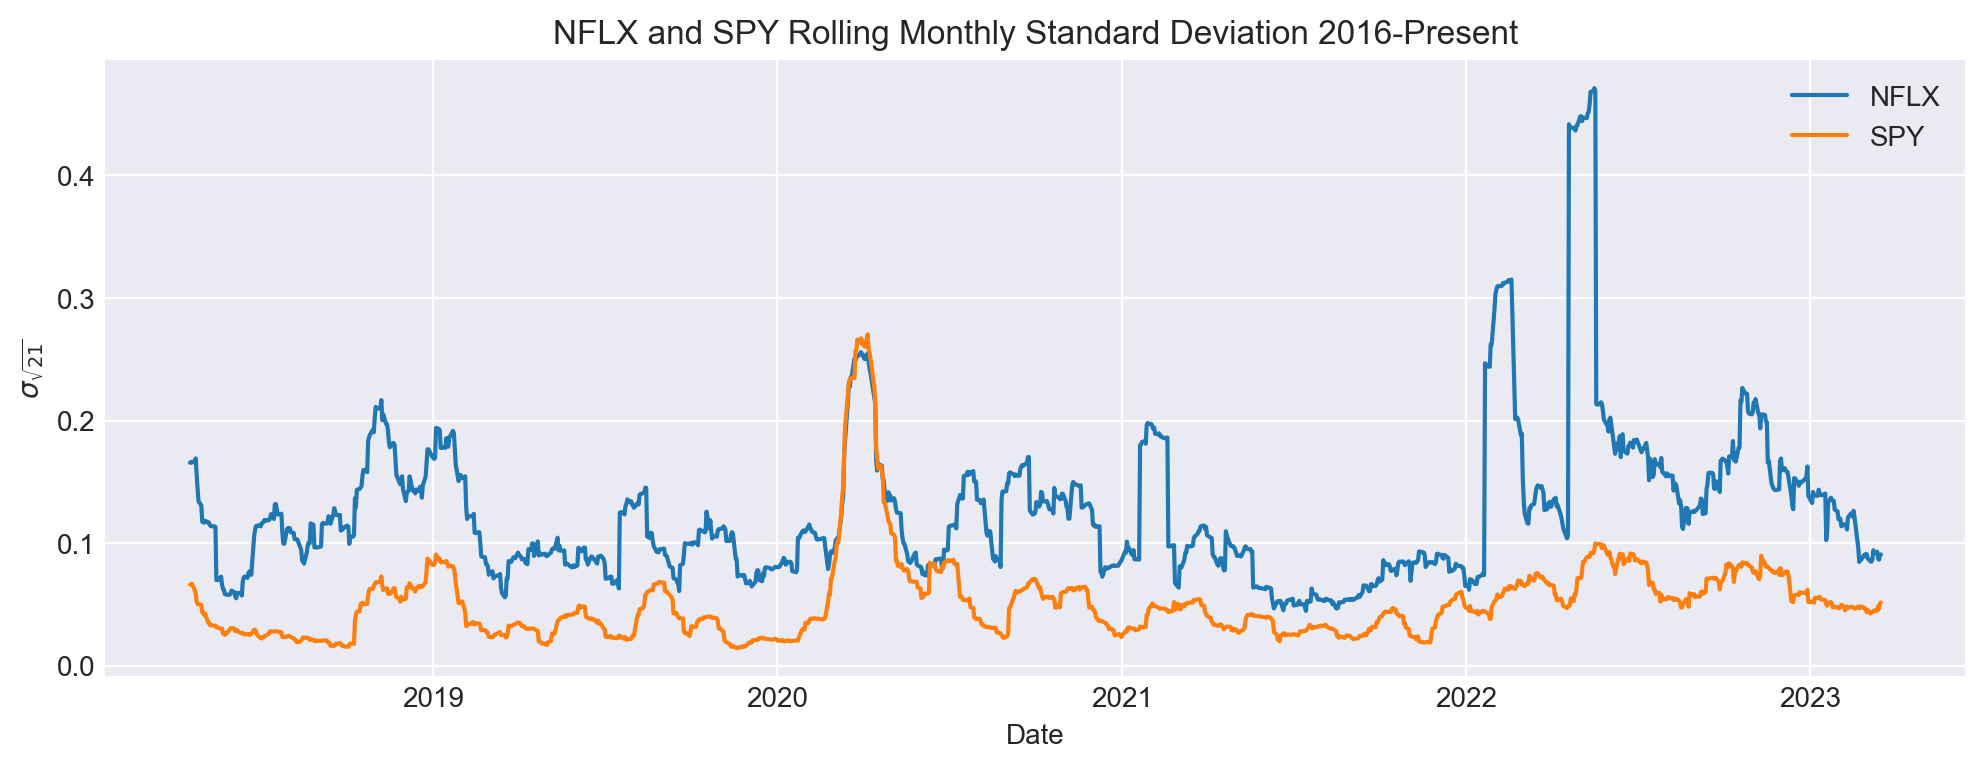

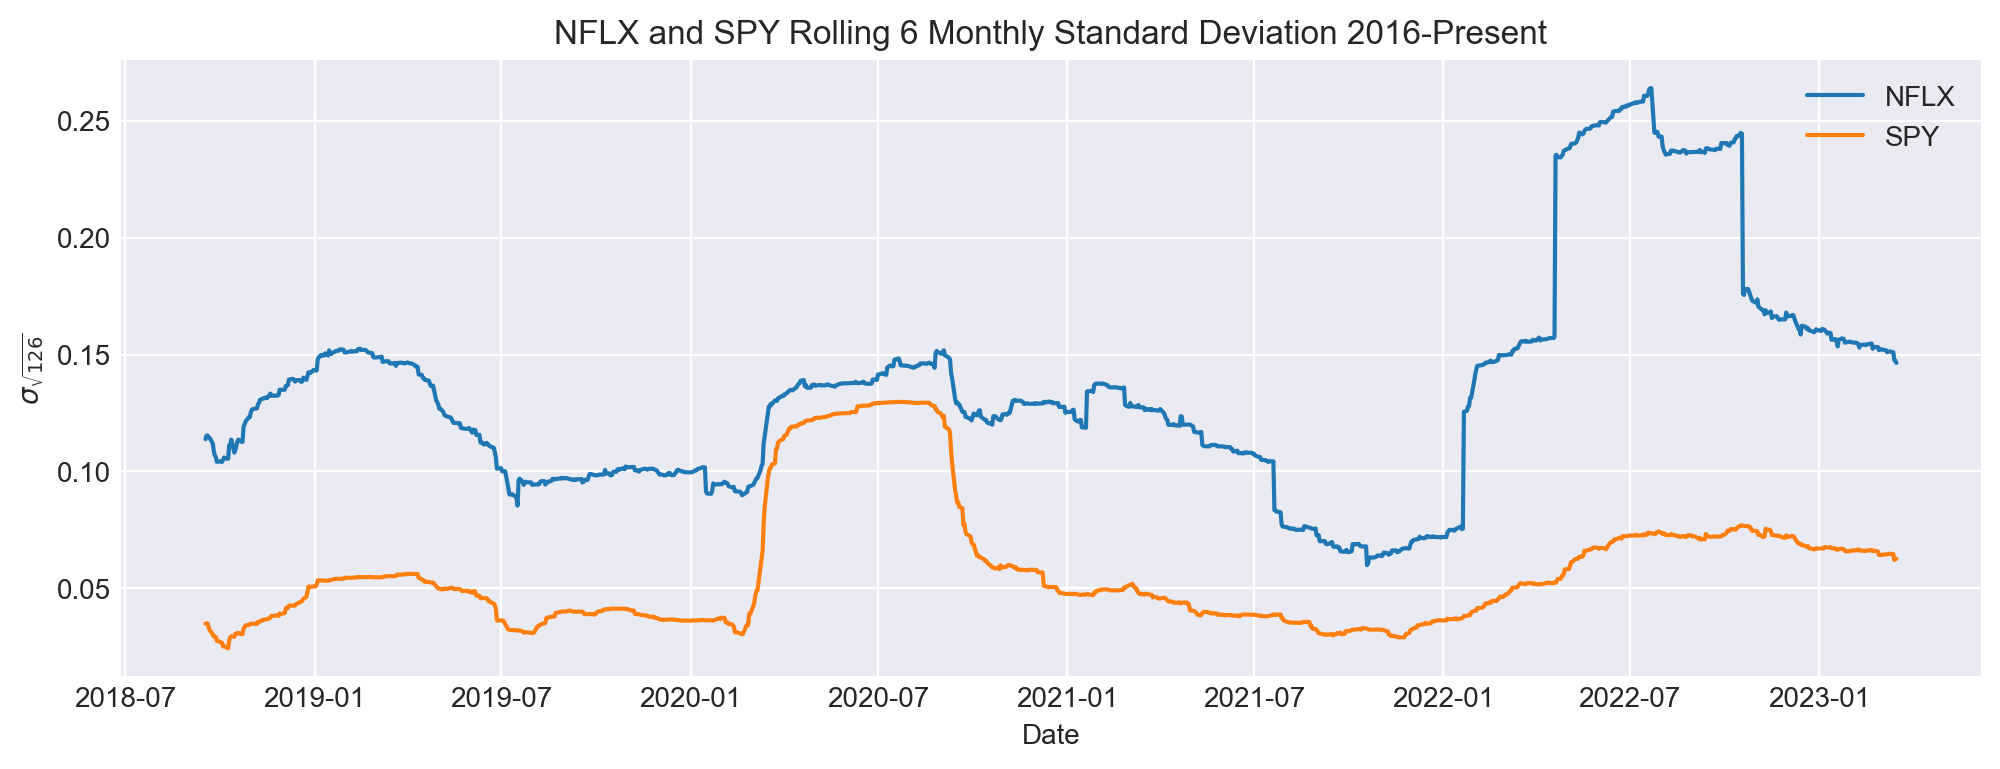

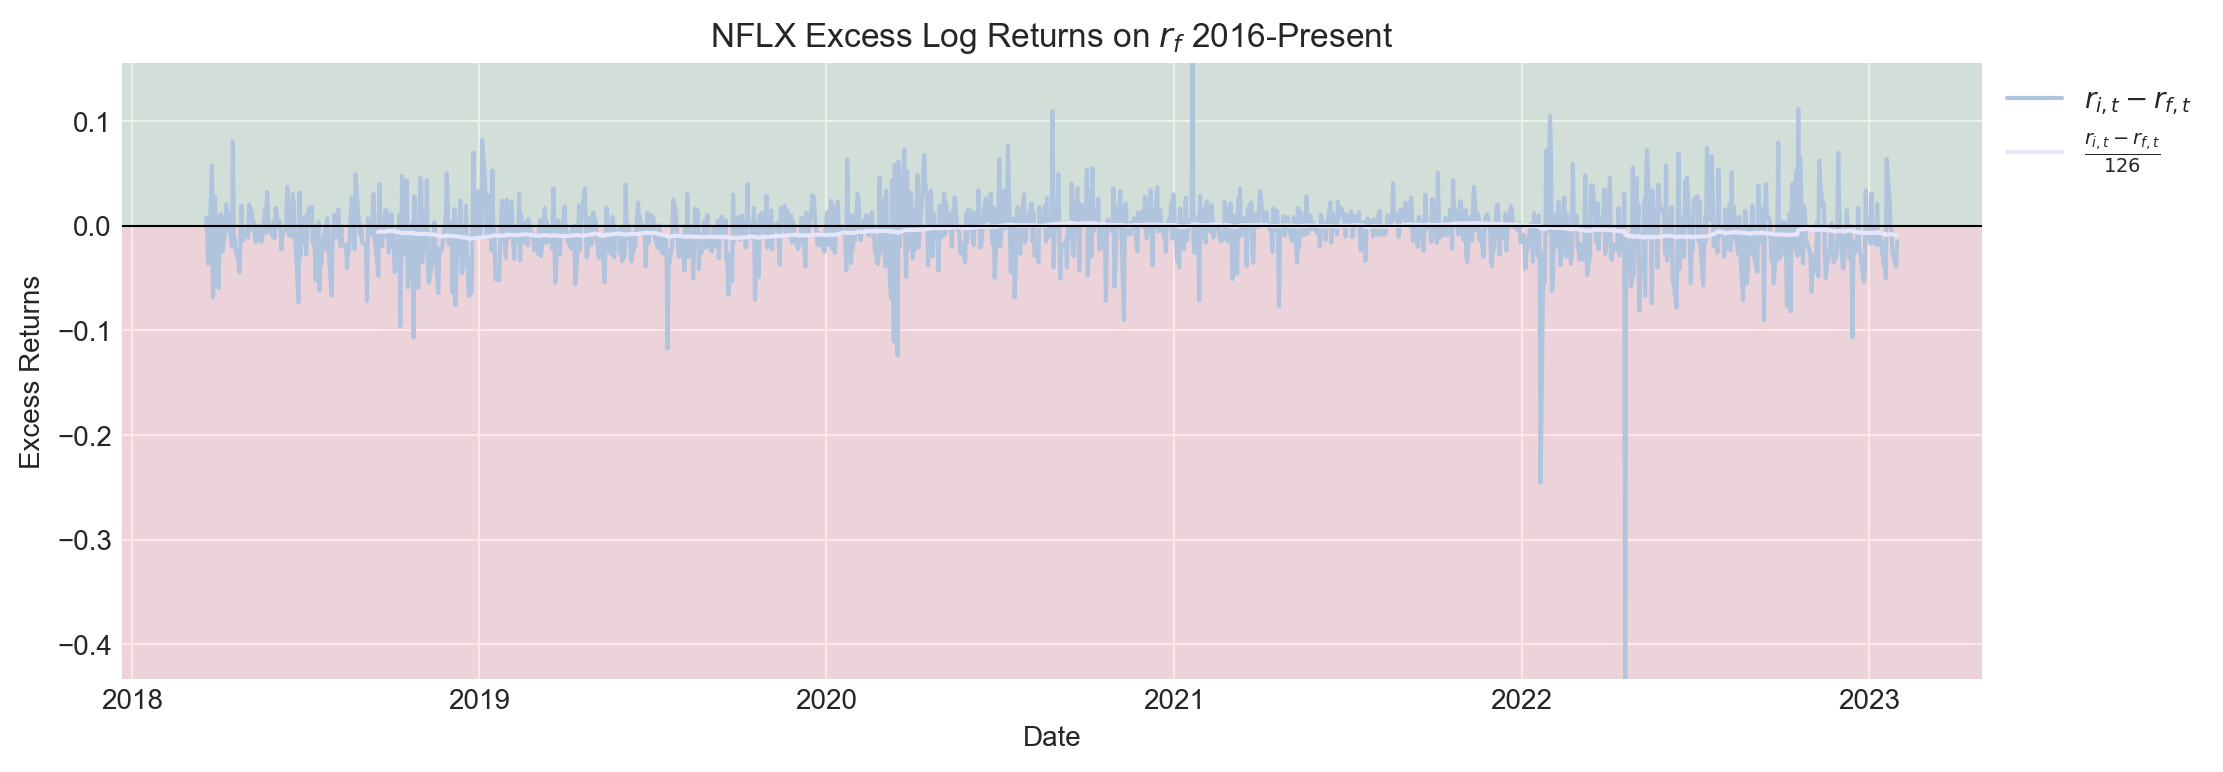

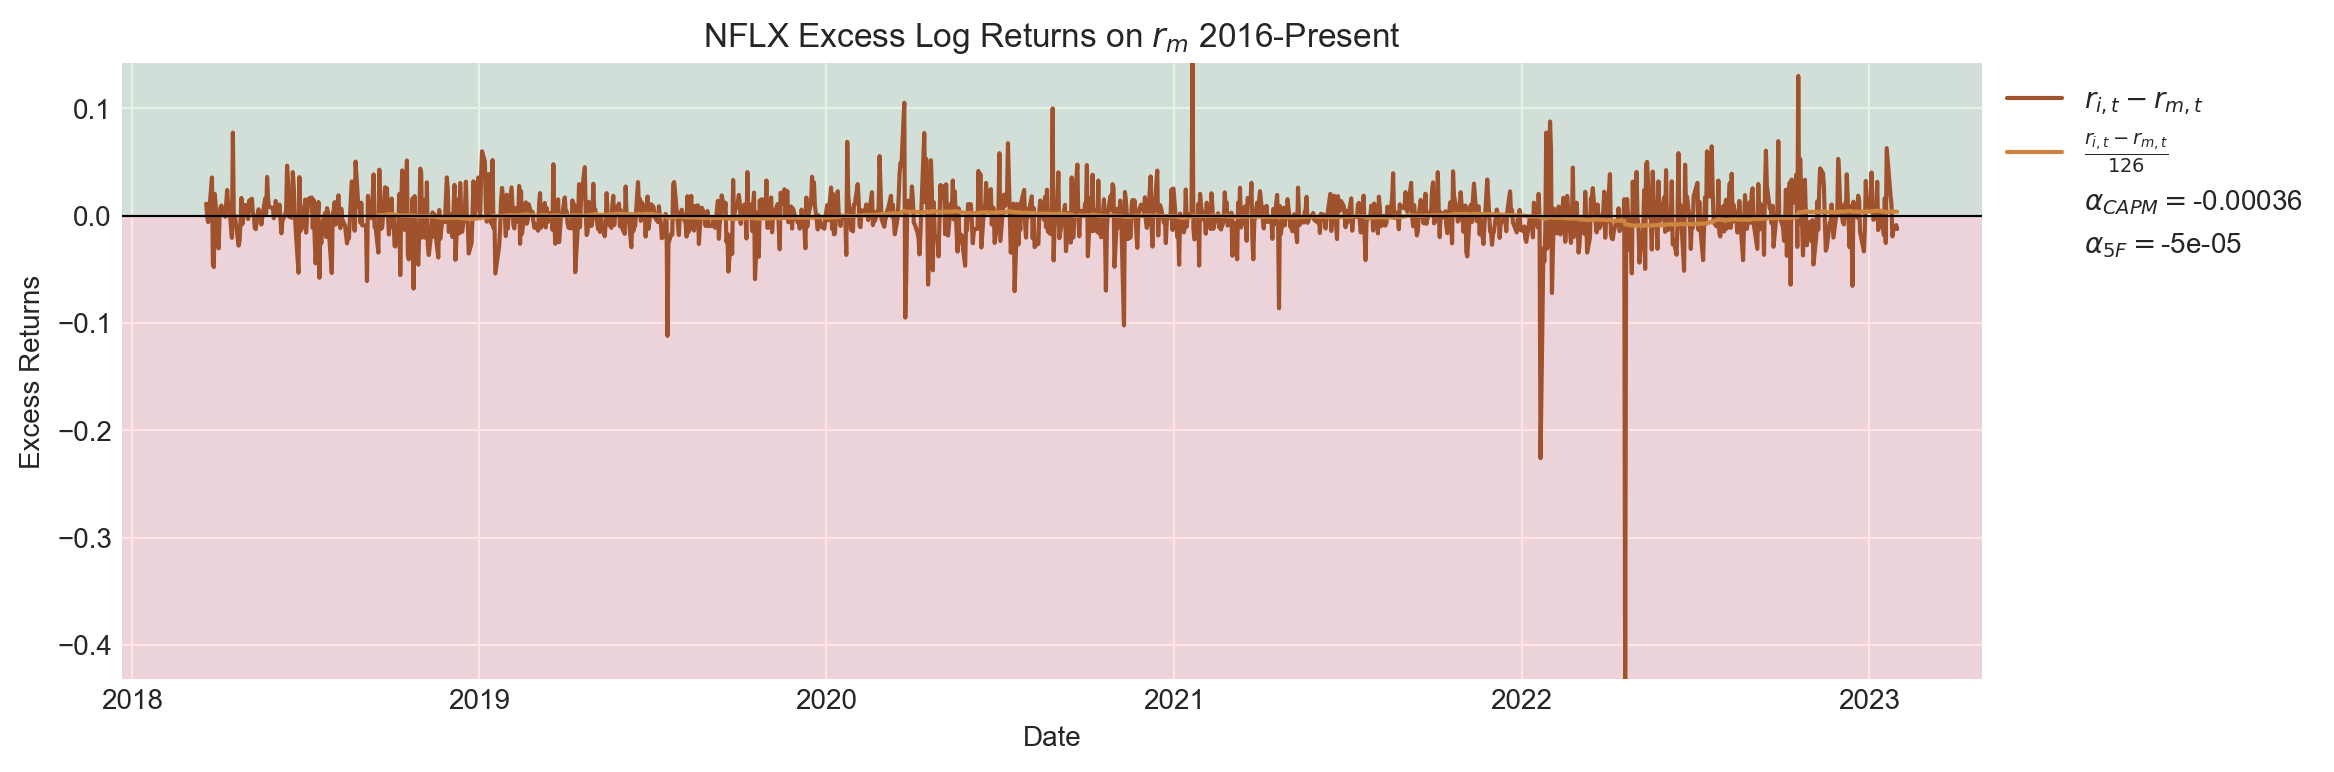

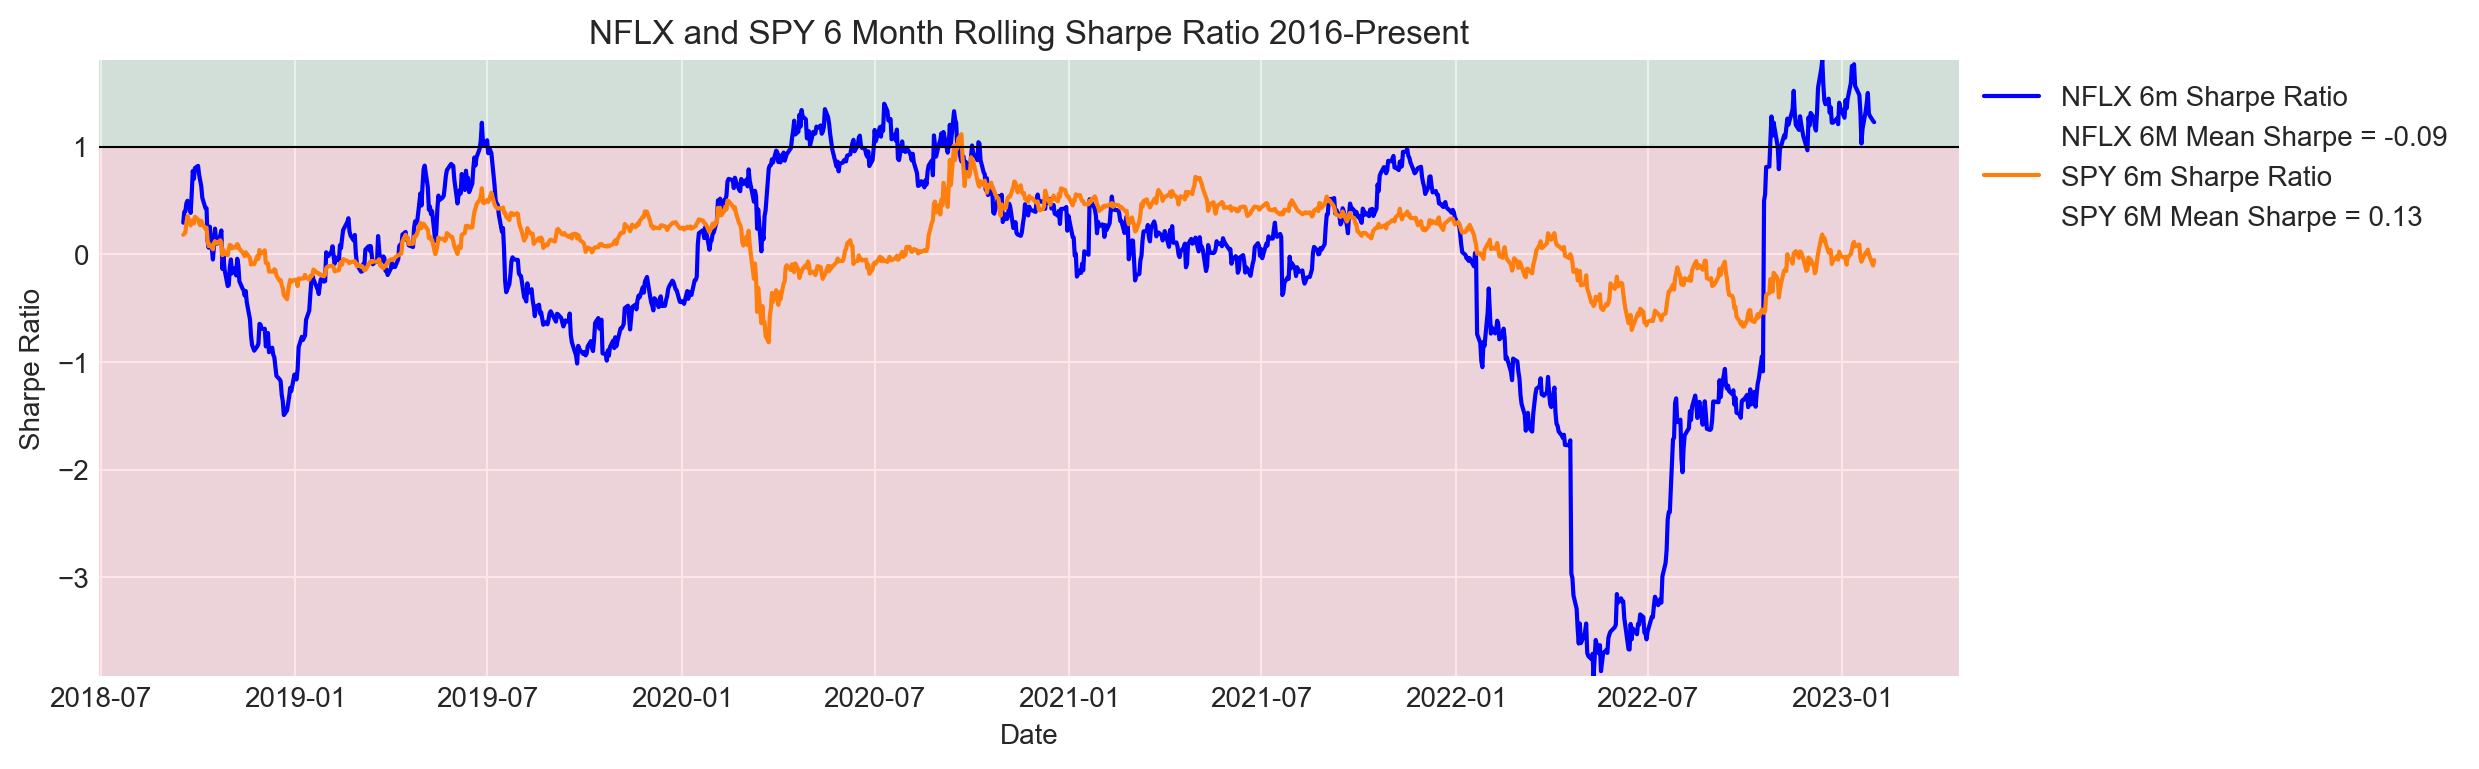



Relevant Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max
NFLX Adj Close,1226.0,0.000099,0.031012,-0.432578,-0.014049,0.000269,0.015289,0.155758
SPY Adj Close,1226.0,0.000399,0.013658,-0.115886,-0.005129,0.000767,0.007178,0.086731
Excess_rf,1226.0,-0.004612,0.031199,-0.433578,-0.019493,-0.004081,0.011207,0.155758
Excess_SPY,1226.0,-0.000300,0.026897,-0.431837,-0.012327,-0.000992,0.012030,0.142014


In [18]:
# Plots:
plt.style.use('seaborn-darkgrid')

# Closes
fig, ax = plt.subplots(figsize=(12,4), dpi=200)
ax.plot(stock, label = f'{ticker.upper()}')
ax.plot(spy, label = 'SPY')
ax.legend(loc='best')
ax.set_title(f'{ticker.upper()}  and SPY Daily Adjusted Close Prices 2016-Present')
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted Close $')

# Close over Volume
fig, ax = plt.subplots(2, sharex = True, figsize=(16, 8), dpi=200)
plt.tight_layout()
ax[0].plot(ohlcv.index, ohlcv['Close'])
ax[0].set_title(f'{ticker.upper()} Close')
ax[0].set_ylabel('USD ($)')
ax[1].set_title(f'{ticker.upper()} Volume')
ax[1].set_ylabel('Shares Traded')
ax[1].plot(ohlcv.index, ohlcv['Volume'])

# Candlestick chart
mc = mpf.make_marketcolors(up='#0b559f',down='#ff7f0e',
                           edge={'up':'#0b559f', 'down':'#ff7f0e'},
                           wick={'up':'#0b559f','down':'#ff7f0e'},
                           ohlc='black')
s  = mpf.make_mpf_style(base_mpl_style='seaborn-darkgrid',marketcolors=mc)
mpf.plot(ohlcv[f'{datetime.now() - relativedelta(years=1)}':], type="candle", style=s, title=f'{ticker.upper()} 1Y Candlestick Chart', figratio=(12/1200,4/1200))

# Cumulative Compound Returns
fig, ax = plt.subplots(figsize=(12,4), dpi=200)
ax.plot(cum_ret_stock, label = f'{ticker.upper()}')
ax.plot(cum_ret_spy, label = 'SPY')
ax.legend(loc='best')
ax.set_title(f'{ticker.upper()} and SPY 5Y Cumulative Compound Returns')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')

# Log Return Distributions
fig, ax = plt.subplots(figsize=(12,4), dpi=200)
logs = log_stock.join(log_spy, how='inner')
ax = sns.kdeplot(data=logs, fill=True, alpha=0.5);
ax.set_title(f'{ticker.upper()} and SPY Log Returns Distribution Plot 2016-Present')
ax.set_xlabel('Log Returns')
ax.set_ylabel('Density')

# Rolling BETA
fig, ax = plt.subplots(figsize=(12,4), dpi=200)
ax.plot(rolling_6m_beta, label = r'$\beta_{6M}$')
ax.plot([], [], ' ', label = r'$\mu_{\beta_{6M}}= $'+ f'{rolling_6m_beta.mean().round(2)}')
ax.plot([], [], ' ', label = r'$\beta_{CAPM}= $'+ f'{CAPM_beta.round(2)}')
ax.plot([], [], ' ', label = r'$\beta_{5F}= $'+ f'{FF_beta.round(2)}' )
ax.axhline(1, color='black', linewidth=0.75)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_title(f'{ticker.upper()} Rolling 6 Month Beta 2016-Present')
ax.set_xlabel('Date')
ax.set_ylabel(r'$\beta$')

# Rolling SIGMAs
fig, ax = plt.subplots(figsize=(12,4), dpi=200)
ax.plot(rolling_21d_std, label=f'{ticker.upper()}')
ax.plot(rolling_21d_std_spy, label='SPY')
ax.legend(loc='best')
ax.set_title(f'{ticker.upper()} and SPY Rolling Monthly Standard Deviation 2016-Present')
ax.set_xlabel('Date')
ax.set_ylabel(r'$\sigma_{\sqrt{21}}$')

fig, ax = plt.subplots(figsize=(12,4), dpi=200)
ax.plot(rolling_6m_std, label=f'{ticker.upper()}')
ax.plot(rolling_6m_std_spy, label='SPY')
ax.legend(loc='best')
ax.set_title(f'{ticker.upper()} and SPY Rolling 6 Monthly Standard Deviation 2016-Present')
ax.set_xlabel('Date')
ax.set_ylabel(r'$\sigma_{\sqrt{126}}$')

# Excess Returns
fig, ax = plt.subplots(figsize=(12,4), dpi=200)
ax.plot(fama_french['Excess_rf'], color = 'lightsteelblue', label = r'$r_{i,t}-r_{f,t}$')
ax.plot(fama_french['Excess_rf_mean_126'], color = 'lavender', label = r'$\frac{r_{i,t}-r_{f,t}}{126}$')
ax.autoscale(enable=True, axis='y', tight=True)
ax.axhline(0, color='black', linewidth=0.75)
ax.axhspan(0, max(ax.get_ylim()), facecolor='g', alpha=0.1)
ax.axhspan(0, min(ax.get_ylim()), facecolor='r', alpha=0.1)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_title(f'{ticker.upper()} Excess Log Returns on $r_f$ 2016-Present')
ax.set_xlabel('Date')
ax.set_ylabel('Excess Returns')

fig, ax = plt.subplots(figsize=(12,4), dpi=200)
ax.plot(fama_french['Excess_SPY'], color = 'sienna', label = r'$r_{i,t}-r_{m,t}$')
ax.plot(fama_french['Excess_SPY_mean_126'], color = 'peru', label = r'$\frac{r_{i,t}-r_{m,t}}{126}$')
plt.ylim(fama_french['Excess_SPY'].min(), fama_french['Excess_SPY'].max())
ax.plot([], [], ' ', label = r'$\alpha_{CAPM}= $'+ f'{CAPM_alpha.round(5)}')
ax.plot([], [], ' ', label = r'$\alpha_{5F}= $'+ f'{FF_alpha.round(5)}' )
ax.axhline(0, color='black', linewidth=0.75)

ax.autoscale(enable=True, axis='y', tight=True)
ax.axhline(0, color='black', linewidth=0.75)
ax.axhspan(0, max(ax.get_ylim()), facecolor='g', alpha=0.1)
ax.axhspan(0, min(ax.get_ylim()), facecolor='r', alpha=0.1)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_title(f'{ticker.upper()} Excess Log Returns on $r_m$ 2016-Present')
ax.set_xlabel('Date')
ax.set_ylabel('Excess Returns')

# SHARPE Ratio
fig, ax = plt.subplots(figsize=(12,4), dpi=200)
ax.plot(sharpe_stock_6m, color = 'blue', label = f'{ticker.upper()} 6m Sharpe Ratio')
ax.plot([], [], ' ', label = f'{ticker.upper()} 6M Mean Sharpe = ' + f'{sharpe_stock_6m.mean().round(2)}')
ax.plot(sharpe_spy_6m, color = '#ff7f0e', label = 'SPY 6m Sharpe Ratio')
ax.plot([], [], ' ', label = 'SPY 6M Mean Sharpe = ' + f'{sharpe_spy_6m.mean().round(2)}')
ax.axhline(1, color='black', linewidth=0.75)
ax.autoscale(enable=True, axis='y', tight=True)
ax.axhspan(1, max(ax.get_ylim()), facecolor='g', alpha=0.1)
ax.axhspan(1, min(ax.get_ylim()), facecolor='r', alpha=0.1)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_title(f'{ticker.upper()} and SPY 6 Month Rolling Sharpe Ratio 2016-Present')
ax.set_xlabel('Date')
ax.set_ylabel('Sharpe Ratio')
plt.show();

print('\n')
print('Relevant Descriptive Statistics:')
fama_french[[f'{ticker.upper()} Adj Close', 'SPY Adj Close', 'Excess_rf', 'Excess_SPY']].describe().T

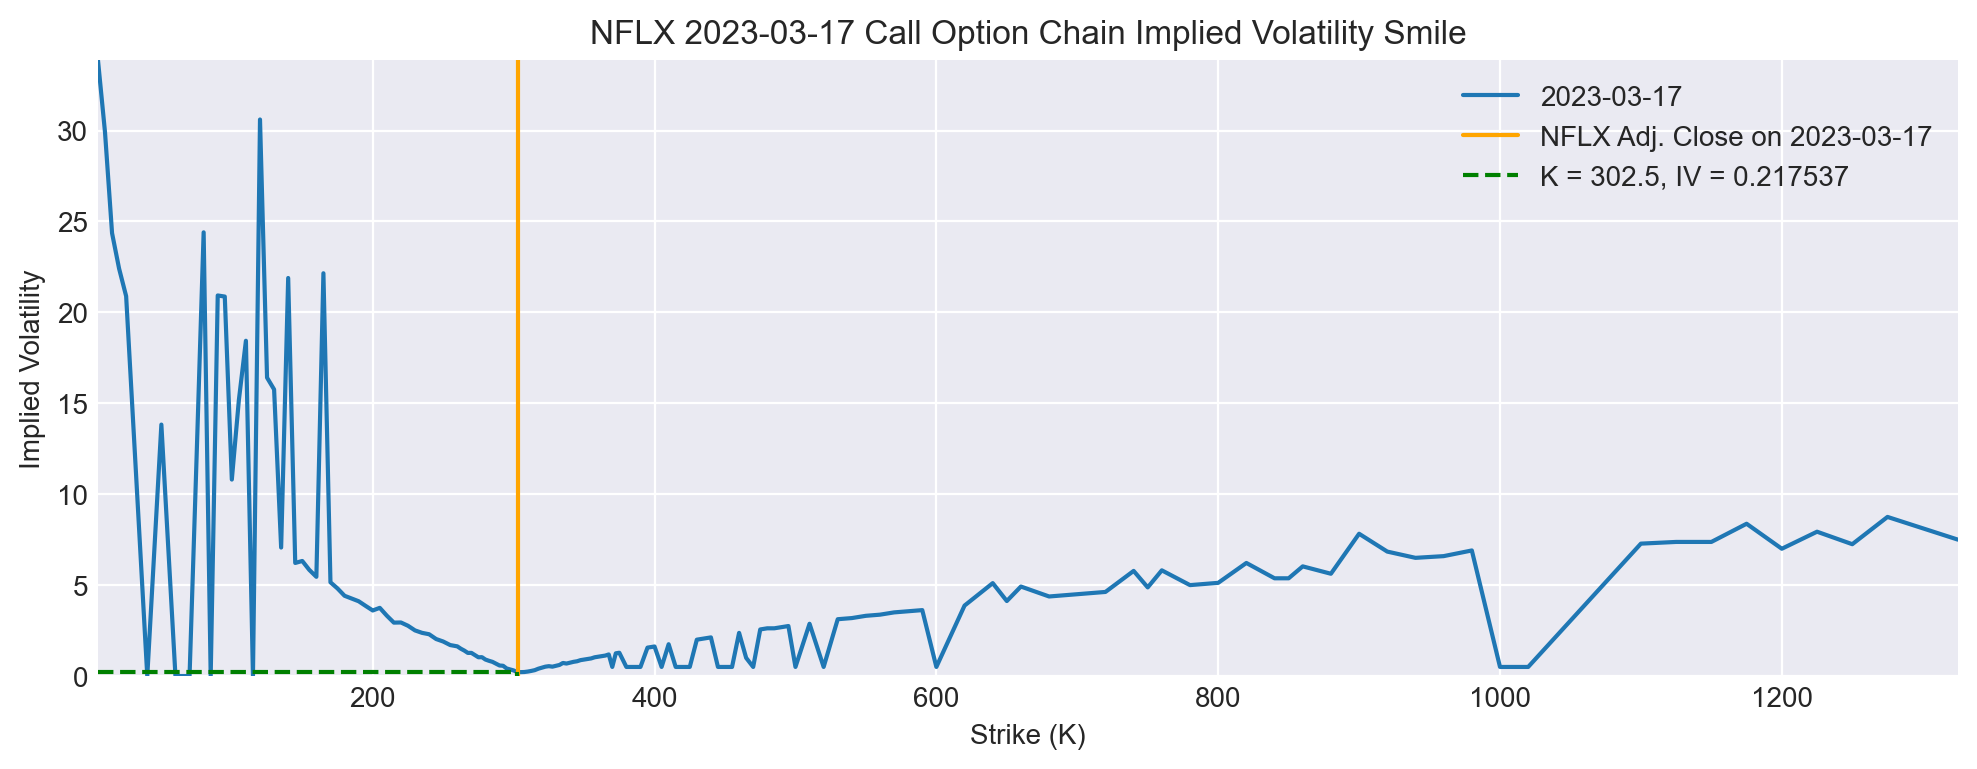


 Implied Volatility of NFLX is currently ~ 0.217537
IV is inferred by finding the iv of the nearest expiring options call chain, under the impression that the call chain expiring at the current price is the iv of the current stock.


In [22]:
# Plot IV of options from options chain 
expiry_dates = options.get_expiration_dates(ticker)
expiration = dps.parse(expiry_dates[0], fuzzy=True)
expiration = expiration.date() 
opt = yf.Ticker(ticker).option_chain(str(expiration))
calls = opt.calls

# Find nearest strike and corresponding IV:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
    
K = find_nearest(calls['strike'], stock[-1])
find_iv = list(calls['impliedVolatility'][calls['strike']==find_nearest(calls['strike'], stock[-1])])
iv = round(find_iv[0],6)

fig, ax = plt.subplots(figsize=(12,4), dpi=200)
plt.xlim(calls['strike'].min(), calls['strike'].max())
plt.ylim(calls['impliedVolatility'].min(), calls['impliedVolatility'].max())
ax.plot(calls['strike'], calls['impliedVolatility'], label=str(expiration))

ax.axvline(stock[-1], label = f'{ticker.upper()} Adj. Close on {stock.index[-1].date()}', color = 'orange')
plt.vlines(K, ymin = calls['impliedVolatility'].min(), ymax=iv, color = 'green', linestyle = '--')
plt.hlines(iv, xmin = calls['strike'].min(), xmax=K,  color = 'green', linestyle = '--', label = f'K = {K}, IV = {iv}')

ax.legend(loc='best')
ax.set_title(f'{ticker.upper()} {expiration} Call Option Chain Implied Volatility Smile')
ax.set_xlabel('Strike (K)')
ax.set_ylabel('Implied Volatility')
plt.show();


print(f'\nImplied Volatility of {ticker.upper()} is currently ~ {iv}')
print('IV is inferred by finding the iv of the nearest expiring options call chain, under the impression that the call chain expiring at the current price is the iv of the current stock.')

In [ ]:
# LSTM Model and Forecast - predicting this stock only -- biased?
y = stock
y = y.values.reshape(-1, 1)

# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

# generate the input and output sequences
n_lookback = 5  # length of input sequences (lookback period)
n_forecast = 5  # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

# fit the model
model = Sequential()
model.add(LSTM(units=100, activation='sigmoid', return_sequences=True, input_shape=(n_lookback, 1)))
model.add(Dense(n_forecast))
model.compile(loss='mean_squared_error', optimizer='adam')
early_stopping = EarlyStopping(monitor = 'loss', patience = 5)
model.fit(X, Y, epochs=100, batch_size=5, callbacks=[early_stopping])
loss_per_epoch = model.history.history['loss']

plt.figure(figsize=(10,6), dpi=100)
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('LSTM Model Loss per Epoch:')


# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)
Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)
forecast = Y_[-5:].flatten().tolist()

from datetime import timedelta, date
days = pd.date_range(datetime.today(), periods=5).strftime("%d-%m-%Y").tolist()
days = pd.to_datetime(days)

future_df = pd.DataFrame(index = days)
future_df['Forecast'] = forecast
evs = stock[-5:]
forecast_df = pd.concat([evs,future_df], ignore_index=True)
date = [*evs.index, *days]
date[9] = datetime.strptime(str(date[9]), "%Y-%d-%m %H:%M:%S").strftime("%Y-%m-%d %H:%M:%S")
forecast_df['Date'] = date
forecast_df.set_index('Date', inplace=True)
forecast_df = forecast_df.rename(columns={0: "Adj. Close"})

plt.figure(figsize = (10,8), dpi=100)
plt.plot(forecast_df['Adj. Close'], label = f'{ticker.upper()} Adj. Close')
plt.plot(forecast_df['Forecast'], label = 'Forecast')
plt.legend(loc='best')
plt.title(f'{ticker.upper()} LSTM Forecast')

In [ ]:
ticker = input('Enter chosen Ticker here: ')
start = datetime.now() - relativedelta(years=5)
end = datetime.now()
stock = pdr.get_data_yahoo(ticker.upper(), start=start, end=end)
spy = pdr.get_data_yahoo('SPY', start=start, end=end)
ohlcv = stock.loc[:,['Open', 'High', 'Low', 'Close', 'Volume']]
stock=stock['Adj Close']
spy = spy['Adj Close']

# log returns
log_stock = np.log(stock/stock.shift())
log_spy = np.log(spy/spy.shift())
# cum returns
cum_ret_stock = (log_stock+1).cumprod()-1
cum_ret_spy = (log_spy+1).cumprod()-1

# obtain fama-french data:
fivef = pdr.DataReader('F-F_Research_Data_5_Factors_2x3_daily','famafrench',start=start, end=end)
fivef = fivef[0] # fivef is a dictionary the first part of which is the table we want.
fivef['Mkt'] = fivef['Mkt-RF'] + fivef['RF'] # obtain market returns
fivef.index.names = ['Date']

# BETA    
cov = log_stock.cov(log_spy)
var = log_spy.var()
beta = cov/var

# Rolling BETA
rolling_6m_cov = log_stock.rolling(126).cov(log_spy)
rolling_6m_var = log_spy.rolling(126).var()
rolling_6m_beta = rolling_6m_cov/rolling_6m_var

# Rolling SIGMAs
rolling_21d_std = log_stock.rolling(21).std()*np.sqrt(21)
rolling_6m_std =  log_stock.rolling(126).std()*np.sqrt(21)
rolling_ann_std = log_stock.rolling(252).std()*np.sqrt(252)
rolling_21d_std_spy = log_spy.rolling(21).std()*np.sqrt(21)
rolling_6m_std_spy =  log_spy.rolling(126).std()*np.sqrt(21)
rolling_ann_std_spy = log_spy.rolling(252).std()*np.sqrt(252)

# Combine FF with stock returns
log_stock = log_stock.rename(f'{ticker.upper()} Adj Close')
log_stock = log_stock.to_frame()
log_spy = log_spy.rename('SPY Adj Close')
log_spy = log_spy.to_frame()
fama_french = log_stock.join(fivef, how='inner')
fama_french = log_spy.join(fama_french, how='inner')

# Add Excess Returns:
fama_french['Excess_rf'] = fama_french[f'{ticker.upper()} Adj Close']-fama_french['RF']
fama_french['Excess_SPY'] = fama_french[f'{ticker.upper()} Adj Close']-fama_french['SPY Adj Close']
# Add rolling mean excess returns:
fama_french['Excess_rf_mean_126'] = fama_french['Excess_rf'].rolling(126).mean()
fama_french['Excess_SPY_mean_126'] = fama_french['Excess_SPY'].rolling(126).mean()

# Rolling SHARPEs:
fama_french['rm-rf'] = fama_french['SPY Adj Close']-fama_french['RF']
log_stock_6m = np.log(stock/stock.shift(126))
log_spy_6m = np.log(spy/spy.shift(126))
sharpe_stock_6m = (log_stock_6m-fama_french['RF'])/(fama_french['Excess_rf'].std()*np.sqrt(126))
sharpe_spy_6m = (log_spy_6m-fama_french['RF'])/(fama_french['Excess_rf'].std()*np.sqrt(126))

# CAPM alpha:
y = fama_french[f'{ticker.upper()} Adj Close'].dropna().values
x = fama_french['SPY Adj Close'].dropna().values
x = sm.add_constant(x)
capm = sm.OLS(y,x)
capm_results = capm.fit()
CAPM_beta = capm_results.params[1]
CAPM_alpha = capm_results.params[0]

# Five-Factor alpha:
y_2 = fama_french[f'{ticker.upper()} Adj Close'][1:].values
x_2= fama_french[['SPY Adj Close', 'SMB', 'HML', 'RMW', 'CMA']][1:].values
x_2 = sm.add_constant(x_2)
ff = sm.OLS(y_2,x_2)
ff_results = ff.fit()
FF_beta = ff_results.params[1]
FF_alpha = ff_results.params[0]

# Plots:
plt.style.use('seaborn-darkgrid')

# Closes
fig, ax = plt.subplots(figsize=(12,4), dpi=200)
ax.plot(stock, label = f'{ticker.upper()}')
ax.plot(spy, label = 'SPY')
ax.legend(loc='best')
ax.set_title(f'{ticker.upper()}  and SPY Daily Adjusted Close Prices 2016-Present')
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted Close $')

# Close over Volume
fig, ax = plt.subplots(2, sharex = True, figsize=(16, 8), dpi=200)
plt.tight_layout()
ax[0].plot(ohlcv.index, ohlcv['Close'])
ax[0].set_title(f'{ticker.upper()} Close')
ax[0].set_ylabel('USD ($)')
ax[1].set_title(f'{ticker.upper()} Volume')
ax[1].set_ylabel('Shares Traded')
ax[1].plot(ohlcv.index, ohlcv['Volume'])

# Candlestick chart
mc = mpf.make_marketcolors(up='#0b559f',down='#ff7f0e',
                           edge={'up':'#0b559f', 'down':'#ff7f0e'},
                           wick={'up':'#0b559f','down':'#ff7f0e'},
                           ohlc='black')
s  = mpf.make_mpf_style(base_mpl_style='seaborn-darkgrid',marketcolors=mc)
mpf.plot(ohlcv[f'{datetime.now() - relativedelta(years=1)}':], type="candle", style=s, title=f'{ticker.upper()} 1Y Candlestick Chart', figratio=(12/1200,4/1200))

# Cumulative Compound Returns
fig, ax = plt.subplots(figsize=(12,4), dpi=200)
ax.plot(cum_ret_stock, label = f'{ticker.upper()}')
ax.plot(cum_ret_spy, label = 'SPY')
ax.legend(loc='best')
ax.set_title(f'{ticker.upper()} and SPY 5Y Cumulative Compound Returns')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')

# Log Return Distributions
fig, ax = plt.subplots(figsize=(12,4), dpi=200)
logs = log_stock.join(log_spy, how='inner')
ax = sns.kdeplot(data=logs, fill=True, alpha=0.5);
ax.set_title(f'{ticker.upper()} and SPY Log Returns Distribution Plot 2016-Present')
ax.set_xlabel('Log Returns')
ax.set_ylabel('Density')

# Rolling BETA
fig, ax = plt.subplots(figsize=(12,4), dpi=200)
ax.plot(rolling_6m_beta, label = r'$\beta_{6M}$')
ax.plot([], [], ' ', label = r'$\mu_{\beta_{6M}}= $'+ f'{rolling_6m_beta.mean().round(2)}')
ax.plot([], [], ' ', label = r'$\beta_{CAPM}= $'+ f'{CAPM_beta.round(2)}')
ax.plot([], [], ' ', label = r'$\beta_{5F}= $'+ f'{FF_beta.round(2)}' )
ax.axhline(1, color='black', linewidth=0.75)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_title(f'{ticker.upper()} Rolling 6 Month Beta 2016-Present')
ax.set_xlabel('Date')
ax.set_ylabel(r'$\beta$')

# Rolling SIGMAs
fig, ax = plt.subplots(figsize=(12,4), dpi=200)
ax.plot(rolling_21d_std, label=f'{ticker.upper()}')
ax.plot(rolling_21d_std_spy, label='SPY')
ax.legend(loc='best')
ax.set_title(f'{ticker.upper()} and SPY Rolling Monthly Standard Deviation 2016-Present')
ax.set_xlabel('Date')
ax.set_ylabel(r'$\sigma_{\sqrt{21}}$')

fig, ax = plt.subplots(figsize=(12,4), dpi=200)
ax.plot(rolling_6m_std, label=f'{ticker.upper()}')
ax.plot(rolling_6m_std_spy, label='SPY')
ax.legend(loc='best')
ax.set_title(f'{ticker.upper()} and SPY Rolling 6 Monthly Standard Deviation 2016-Present')
ax.set_xlabel('Date')
ax.set_ylabel(r'$\sigma_{\sqrt{126}}$')

# Excess Returns
fig, ax = plt.subplots(figsize=(12,4), dpi=200)
ax.plot(fama_french['Excess_rf'], color = 'lightsteelblue', label = r'$r_{i,t}-r_{f,t}$')
ax.plot(fama_french['Excess_rf_mean_126'], color = 'lavender', label = r'$\frac{r_{i,t}-r_{f,t}}{126}$')
ax.autoscale(enable=True, axis='y', tight=True)
ax.axhline(0, color='black', linewidth=0.75)
ax.axhspan(0, max(ax.get_ylim()), facecolor='g', alpha=0.1)
ax.axhspan(0, min(ax.get_ylim()), facecolor='r', alpha=0.1)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_title(f'{ticker.upper()} Excess Log Returns on $r_f$ 2016-Present')
ax.set_xlabel('Date')
ax.set_ylabel('Excess Returns')

fig, ax = plt.subplots(figsize=(12,4), dpi=200)
ax.plot(fama_french['Excess_SPY'], color = 'sienna', label = r'$r_{i,t}-r_{m,t}$')
ax.plot(fama_french['Excess_SPY_mean_126'], color = 'peru', label = r'$\frac{r_{i,t}-r_{m,t}}{126}$')
plt.ylim(fama_french['Excess_SPY'].min(), fama_french['Excess_SPY'].max())
ax.plot([], [], ' ', label = r'$\alpha_{CAPM}= $'+ f'{CAPM_alpha.round(5)}')
ax.plot([], [], ' ', label = r'$\alpha_{5F}= $'+ f'{FF_alpha.round(5)}' )
ax.axhline(0, color='black', linewidth=0.75)

ax.autoscale(enable=True, axis='y', tight=True)
ax.axhline(0, color='black', linewidth=0.75)
ax.axhspan(0, max(ax.get_ylim()), facecolor='g', alpha=0.1)
ax.axhspan(0, min(ax.get_ylim()), facecolor='r', alpha=0.1)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_title(f'{ticker.upper()} Excess Log Returns on $r_m$ 2016-Present')
ax.set_xlabel('Date')
ax.set_ylabel('Excess Returns')

# SHARPE Ratio
fig, ax = plt.subplots(figsize=(12,4), dpi=200)
ax.plot(sharpe_stock_6m, color = 'blue', label = f'{ticker.upper()} 6m Sharpe Ratio')
ax.plot([], [], ' ', label = f'{ticker.upper()} 6M Mean Sharpe = ' + f'{sharpe_stock_6m.mean().round(2)}')
ax.plot(sharpe_spy_6m, color = '#ff7f0e', label = 'SPY 6m Sharpe Ratio')
ax.plot([], [], ' ', label = 'SPY 6M Mean Sharpe = ' + f'{sharpe_spy_6m.mean().round(2)}')
ax.axhline(1, color='black', linewidth=0.75)
ax.autoscale(enable=True, axis='y', tight=True)
ax.axhspan(1, max(ax.get_ylim()), facecolor='g', alpha=0.1)
ax.axhspan(1, min(ax.get_ylim()), facecolor='r', alpha=0.1)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_title(f'{ticker.upper()} and SPY 6 Month Rolling Sharpe Ratio 2016-Present')
ax.set_xlabel('Date')
ax.set_ylabel('Sharpe Ratio')
plt.show();

print('\n')
print('\n')

# Add Ratio Analysis of Fundamentals: balance sheet & cashflow 
fundamentals = yf.Ticker(ticker)
balance_sheet = fundamentals.balance_sheet.T
cashflow = fundamentals.cashflow.T
financials = fundamentals.financials.T
shares_outstanding = balance_sheet['Common Stock']/ohlcv['Close'][-1]
# Ratio Analysis:
wcap = np.array(balance_sheet['Total Current Assets']/balance_sheet['Total Current Liabilities'])
quick = np.array(balance_sheet['Total Current Assets']/balance_sheet['Total Current Liabilities'])
lev = np.array(balance_sheet['Total Liab']/balance_sheet['Total Stockholder Equity'])
eps = np.array(cashflow['Net Income']/shares_outstanding)
pe = np.array(ohlcv['Close'][-1]/eps)
cash = np.array(balance_sheet['Cash']/balance_sheet['Total Current Liabilities'])
netmargin = np.array(financials['Net Income']/financials['Total Revenue'])
rota = np.array(financials['Ebit']/balance_sheet['Total Assets'])
roe = np.array(financials['Net Income']/balance_sheet['Total Stockholder Equity'])

# Trend Analysis:
plt.figure(dpi=150)
plt.plot(financials['Total Revenue'], label = 'Revenue', linestyle = '-', marker = 's')
plt.plot(cashflow['Net Income'], label = 'Net Income', linestyle = '-', marker = 's')
plt.xticks(ticks = cashflow.index, labels = [2021, 2020, 2019, 2018])
plt.title('Trend Analysis: Revenue and Net Income')
plt.xlabel('Year')
plt.ylabel('$ Hundreds of Billions')
plt.legend()

plt.figure(dpi=150)
year = [2021, 2020, 2019, 2018]
plt.bar(year, wcap)
plt.plot(year, wcap, label = 'Trendline', marker = '.', color = 'orange')
for i in (range(len(wcap))):
        plt.text(year[i],wcap[i],wcap[i].round(2),ha = 'center', va = 'bottom', color = '#0b559f')
plt.xticks(ticks = year, labels = [2021, 2020, 2019, 2018])
plt.title('Trend Analysis: Working Capital Ratio')
plt.xlabel('Year')

plt.figure(dpi=150)
plt.bar(year, quick)
plt.plot(year, quick, label = 'Trendline', marker = '.', color = 'orange')
for i in (range(len(quick))):
        plt.text(year[i],quick[i],quick[i].round(2),ha = 'center', va = 'bottom', color = '#0b559f')
plt.xticks(ticks = year, labels = [2021, 2020, 2019, 2018])
plt.title('Trend Analysis: Quick Ratio')
plt.xlabel('Year')

plt.figure(dpi=150)
plt.bar(year, lev)
plt.plot(year, lev, label = 'Trendline', marker = '.', color = 'orange')
for i in (range(len(lev))):
        plt.text(year[i],lev[i],lev[i].round(2),ha = 'center', va = 'bottom', color = '#0b559f')
plt.xticks(ticks = year, labels = [2021, 2020, 2019, 2018])
plt.title('Trend Analysis: Leverage Ratio')
plt.xlabel('Year')

plt.figure(dpi=150)
plt.bar(year, eps)
plt.plot(year, eps, label = 'Trendline', marker = '.', color = 'orange')
for i in (range(len(eps))):
        plt.text(year[i],eps[i],eps[i].round(2),ha = 'center', va = 'bottom', color = '#0b559f')
plt.xticks(ticks = year, labels = [2021, 2020, 2019, 2018])
plt.title('Trend Analysis: Earnings Per Share')
plt.xlabel('Year')

plt.figure(dpi=150)
plt.bar(year, pe)
plt.plot(year, pe, label = 'Trendline', marker = '.', color = 'orange')
for i in (range(len(pe))):
        plt.text(year[i],pe[i],pe[i].round(2),ha = 'center', va = 'bottom', color = '#0b559f')
plt.xticks(ticks = year, labels = [2021, 2020, 2019, 2018])
plt.title('Trend Analysis: P:E Ratio')
plt.xlabel('Year')

plt.figure(dpi=150)
plt.bar(year, cash)
plt.plot(year, cash, label = 'Trendline', marker = '.', color = 'orange')
for i in (range(len(cash))):
        plt.text(year[i],cash[i],cash[i].round(2),ha = 'center', va = 'bottom', color = '#0b559f')
plt.xticks(ticks = year, labels = [2021, 2020, 2019, 2018])
plt.title('Trend Analysis: Cash Ratio')
plt.xlabel('Year')

plt.figure(dpi=150)
plt.bar(year, netmargin)
plt.plot(year, netmargin, label = 'Trendline', marker = '.', color = 'orange')
for i in (range(len(netmargin))):
        plt.text(year[i],netmargin[i],round(netmargin[i],2),ha = 'center', va = 'bottom', color = '#0b559f')
plt.xticks(ticks = year, labels = [2021, 2020, 2019, 2018])
plt.title('Trend Analysis: Net Margin')
plt.xlabel('Year')

plt.figure(dpi=150)
plt.bar(year, rota)
plt.plot(year, rota, label = 'Trendline', marker = '.', color = 'orange')
for i in (range(len(rota))):
        plt.text(year[i],rota[i],round(rota[i],2),ha = 'center', va = 'bottom', color = '#0b559f')
plt.xticks(ticks = year, labels = [2021, 2020, 2019, 2018])
plt.title('Trend Analysis: Return on Total Assets')
plt.xlabel('Year')

plt.figure(dpi=150)
plt.bar(year, roe)
plt.plot(year, roe, label = 'Trendline', marker = '.', color = 'orange')
for i in (range(len(roe))):
        plt.text(year[i],roe[i],round(roe[i],2),ha = 'center', va = 'bottom', color = '#0b559f')
plt.xticks(ticks = year, labels = [2021, 2020, 2019, 2018])
plt.title('Trend Analysis: Return on Total Equity')
plt.xlabel('Year')

# ESG Analysis:
import yesg as yesg
try: 
  if fundamentals.sustainability is not None:
    sus = fundamentals.sustainability.T
    yesg = yesg.get_esg_full(ticker)
    peer = list(yesg['avg peer ESG'])
    esg = sus[['environmentScore', 'governanceScore', 'socialScore']].values.sum()
    def addlabels(x,y):
        for i in range(len(x)):
            plt.text(i, y[i], y[i], ha = 'center', va = 'bottom', color='#0b559f')

    plt.figure(dpi=150)
    x = [f'{ticker.upper()}', 'Sector Peer Average']
    y = [esg, round(peer[0],2)]   
    plt.bar(x, y)
    addlabels(x, y)
    plt.title("Comparative ESG Analysis")
    plt.ylabel("ESG Score")
except IndexError:
  pass


print('Relevant Descriptive Statistics:')
fama_french[[f'{ticker.upper()} Adj Close', 'SPY Adj Close', 'Excess_rf', 'Excess_SPY']].describe().T